In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import fisher_exact
import scipy.stats as stats
from scipy.stats import norm, skew
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score, make_scorer
import pickle
from xgboost import XGBClassifier


In [187]:
data = pd.read_csv("train_file.csv")
data1 = pd.read_csv("test_file.csv")
Topic_features  = pd.read_csv("Topic_distribution.csv")

In [7]:
data.iloc[:,-1].value_counts()

SINGLE FAMILY / DUPLEX    18342
COMMERCIAL                 9778
MULTIFAMILY                4102
INSTITUTIONAL               926
INDUSTRIAL                  391
Name: Category, dtype: int64

In [12]:
data.dtypes

Application/Permit Number            int64
Permit Type                         object
Address                             object
Description                         object
Action Type                         object
Work Type                           object
Applicant Name                      object
Application Date                    object
Issue Date                          object
Final Date                          object
Expiration Date                     object
Status                              object
Contractor                          object
Permit and Complaint Status URL     object
Master Use Permit                  float64
Latitude                           float64
Longitude                          float64
Location                            object
Category                            object
dtype: object

In [3]:
def dummies_Encoding(data):
    Permit = pd.get_dummies(data['Permit Type'],prefix='Permit Type',drop_first=True)
    Action = pd.get_dummies(data['Action Type'],prefix='Action Type',drop_first=True)
    Work = pd.get_dummies(data['Work Type'],prefix='Work Type',drop_first=True)
    Statu = pd.get_dummies(data['Status'],prefix='Status',drop_first=True)
    dummy_encode =  pd.concat([Permit,Action,Work,Statu],axis=1)
    return dummy_encode

In [4]:
def date_features(data):
    completed_Submission = ~data['Application Date'].isna()
    Issue_data = ~data['Issue Date'].isna()
    Under_review = (completed_Submission == True) & (Issue_data == False)
    Final_Date = ~data['Final Date'].isna()
    Under_inspection  = (Issue_data == True) & (Final_Date == False)
    not_issued = data['Expiration Date'].isna()
    total_date = (pd.to_datetime(data['Expiration Date']) - pd.to_datetime(data['Application Date'])).astype('timedelta64[D]') 
    total_date[total_date.isna()] =  max(total_date)*2
    date_variables = pd.concat([completed_Submission,Issue_data,Under_review,Final_Date,Under_inspection,not_issued,total_date],axis=1)
    return date_variables

In [40]:
def cluster_labels(data,c1,c2):
    X1 = data['Longitude'].fillna(0)
    X2 = data['Latitude'].fillna(0)
    X = pd.concat([X1,X2],axis=1)
    kmeanModel = KMeans(n_clusters=c1)
    kmeanModel.fit(X)
    gmm = GaussianMixture(n_components=c2)
    gmm.fit(X)
    return kmeanModel,gmm

In [6]:
def contractor_freq(data):
    Freq = data['Contractor'].fillna(0)
    Freq[Freq == 'SEATTLE HOUSING AUTH GENERAL'] = 1
    Freq[Freq == 'SEATTLE SCHOOL DISTRICT (A&S)'] = 2
    Freq[Freq == 'U OF W BUILDING PERMIT'] = 3
    Freq[Freq == 'SEATTLE PARKS DEPT'] = 4
    Freq[(Freq == 'BURGESS DESIGN, INC') | (Freq == 'CITY OF SEA F&FD') | 
        (Freq == 'SAGE HOMES NORTHWEST, LLC')| (Freq == 'IA/INTERIOR ARCHITECTS')  |(Freq == 'SOUND SEISMIC')| (Freq == 'AMAZON.COM')] = 5
    Freq[(Freq == 'PORT OF SEATTLE ENGINEERING') | (Freq == 'BLANKET: BANK OF AMERICA TOWER') | 
        (Freq == 'CITY INVESTORS')| (Freq == 'GREEN CANOPY HOMES')  |(Freq == 'POLYGON WLH LLC')] = 6
    Freq[~((Freq == 1) | (Freq == 2) | (Freq == 3) | (Freq == 0) | (Freq == 4) | (Freq == 5) | (Freq == 6))]= 7 
    return Freq

In [30]:
def scaling(data):
    scaler = StandardScaler()
    scaled=data['Master Use Permit'].fillna(0)
    scaler.fit(scaled.reshape(-1,1))
    return scaler

In [99]:
def processed_data(data):
    date_variables = date_features(data)
    Freq = pd.DataFrame({'Frequ': contractor_freq(data)})
    Processed_data = pd.concat([date_variables,Freq],axis=1)
    return Processed_data

In [136]:
Train_topic = Topic_features[0:len(data2)]
Test_topic = Topic_features[len(data2):len(data2)+len(data1)]
Train_topic.drop(Train_topic.columns[0],axis=1,inplace=True)
Test_topic.drop(Test_topic.columns[0],axis=1,inplace=True)
Test_topic.reset_index(inplace=True)
kmeanModel, gmm = cluster_labels(data,3,5)
X1 = data['Longitude'].fillna(0)
X2 = data['Latitude'].fillna(0)
X = pd.concat([X1,X2],axis=1)
Cluster_L1 = kmeanModel.predict(X)
Cluster_L2 = gmm.predict(X)
clusters_features = pd.concat([pd.DataFrame({'KNN': Cluster_L1}),pd.DataFrame({'EM':Cluster_L2}),X],axis=1)
scaler = scaling(data)
data2 = data.drop('Category', axis=1) 
data_temp = pd.concat([data2,data1],axis=0)
dummy_encode_train = dummies_Encoding(data_temp)
dummy_encode = dummy_encode_train.iloc[0:len(data2)]
dummy_encode_test = dummy_encode_train.iloc[len(data2):len(data2)+len(data1)]
scaled_Mast = scaler.transform(data['Master Use Permit'].fillna(0).reshape(-1,1))
scaled_Mast = pd.DataFrame(scaled_Mast)


ros = RandomOverSampler(random_state=9)
rus = RandomUnderSampler(random_state=8)
smote = SMOTE(random_state=9, kind="borderline2")
Processed_data1 = pd.concat([dummy_encode,processed_data(data),clusters_features,scaled_Mast,Train_topic],axis=1)
#undersampling and over sampling

X_sample_0, y_sample_0 = ros.fit_sample(Processed_data1, data['Category'])
X_sample_s, y_sample_s = smote.fit_sample(Processed_data1, data['Category'])
X_sample_u, y_sample_u =  rus.fit_sample(Processed_data1, data['Category'])
X_train_O,X_test_O,y_train_O,y_test_O = train_test_split(X_sample_0,y_sample_0,test_size = 0.3)
X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X_sample_s,y_sample_s,test_size = 0.3)
X_train_u,X_test_u,y_train_u,y_test_u = train_test_split(X_sample_u,y_sample_u,test_size = 0.3)    

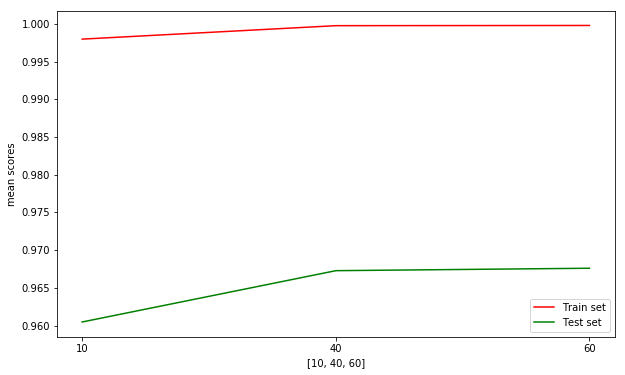

In [216]:
#Random Forest Classifier 
def gridfunc(classifier, parameter, X_train, y_train):
    clf = classifier
    np.random.seed(9)
    parameters = parameter
    f1_scorer = make_scorer(f1_score,average='weighted')
    # Run the grid search
    grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)
    grid_obj = grid_obj.fit(X_train, y_train) 
    return grid_obj          
def hp_cv_scores(grid_obj):
    grid_obj.cv_results_
    mean_test_scores = grid_obj.cv_results_['mean_test_score']
    mean_train_scores = grid_obj.cv_results_['mean_train_score']
    plt.figure(figsize=(10,6)) 
    param_values =[str(x) for x in list(grid_obj.param_grid.items())[0][1]]
    x = np.arange(1, len(param_values)+1)
    plt.plot(x,mean_train_scores, c='r', label='Train set')
    plt.xticks(x,param_values)
    plt.plot(x,mean_test_scores,c='g', label='Test set')
    plt.xlabel(list(grid_obj.param_grid.items())[0][1])
    plt.ylabel('mean scores')
    plt.legend()
    plt.show()
classifier = RandomForestClassifier(random_state=9)
grid = gridfunc(classifier, {'n_estimators': [10, 40, 60]} , X_sample_0, y_sample_0)
hp_cv_scores(grid)

In [225]:
#Test data preparation
scaled_Mast1 = scaler.transform(data1['Master Use Permit'].fillna(0).reshape(-1,1))
scaled_Mast1 = pd.DataFrame(scaled_Mast1)
X1_t = data1['Longitude'].fillna(0)
X2_t = data1['Latitude'].fillna(0)
X_t = pd.concat([X1_t,X2_t],axis=1)
Cluster_L1_t = kmeanModel.predict(X_t)
Cluster_L2_t = gmm.predict(X_t)
clusters_features_t = pd.concat([pd.DataFrame({'KNN': Cluster_L1_t}),pd.DataFrame({'EM':Cluster_L2_t}),X_t],axis=1)
test_processed = pd.concat([dummy_encode_test,processed_data(data1),clusters_features_t,scaled_Mast1,Test_topic],axis=1)
test_processed.drop(['index'], axis=1,inplace = True)


In [260]:
Processed_data1.to_csv('Training.csv')
test_processed.to_csv('Test.csv')

In [259]:
#Prediction for test data
random_forest =  grid.predict(test_processed)
RF_prediction = pd.concat([data1['Application/Permit Number'],pd.DataFrame({'Category':random_forest})],axis=1)
RF_prediction.to_csv('prediction4.csv', sep=',',index = False)

In [162]:
#Boosting technique
model = XGBClassifier(n_estimators=1000)
model.fit(X_train_O, y_train_O)
y_pred = model.predict(X_test_O)
f1_score(y_test_O, y_pred, average='weighted')
Boosting =  model.predict(test_processed.as_matrix())
Boosting_prediction = pd.concat([data1['Application/Permit Number'],pd.DataFrame({'Category':Boosting})],axis=1)
Boosting_prediction.to_csv('prediction2.csv', sep=',',index = False)

0.7836092726477303